In [1]:
import tskit
import numpy as np
from tqdm import tqdm
import msprime

In [2]:
from runsmc import likstepwise
from runsmc import likrec
from runsmc import liknb

In [3]:
import matplotlib.pyplot as plt

In [4]:
NE = 10000
MU = 1.25e-8
REC = 1.25e-8
SEQLEN = 1_000_000
seed = 4977

In [5]:
ts_unary = msprime.sim_ancestry(
        samples = 20,
        coalescing_segments_only=False,
        recombination_rate=REC,
        population_size=NE,
        sequence_length=SEQLEN,
        random_seed=seed,
        model='smc'
        )

In [6]:
ts_unary

In [22]:
def naive_polytomy_maker(ts, keep_nodes):
    tables = ts.dump_tables()
    tables.edges.clear()
    for tree in ts.trees():
        for node in tree.nodes():
            if node in keep_nodes:
                parent = tree.parent(node)
                while parent != tskit.NULL:
                    if parent in keep_nodes:
                        tables.edges.add_row(tree.interval.left, tree.interval.right, parent, node)
                        break
                    parent = tree.parent(parent)
    
    tables.sort()
    tables.edges.squash()
    tables.sort()
    return tables.tree_sequence()

In [ ]:
# test obtaining same mrcas
# subset of paths

In [23]:
def simplify_keeping_unary_in_coal(ts, map_nodes=False):
    """
    Keep the unary regions of nodes that are coalescent at least someone in the tree seq
    Temporary hack until https://github.com/tskit-dev/tskit/issues/2127 is addressed
    """
    tables = ts.dump_tables()
    # remove existing individuals. We will reinstate them later
    tables.individuals.clear()
    tables.nodes.individual = np.full_like(tables.nodes.individual, tskit.NULL)

    _, node_map = ts.simplify(map_nodes=True)
    keep_nodes = np.where(node_map != tskit.NULL)[0]
    # Add an individual for each coalescent node, so we can run
    # simplify(keep_unary_in_individuals=True) to leave the unary portions in.
    for u in keep_nodes:
        i = tables.individuals.add_row()
        tables.nodes[u] = tables.nodes[u].replace(individual=i)
    node_map = tables.simplify(keep_unary_in_individuals=True, filter_individuals=False)

    # Reinstate individuals
    tables.individuals.clear()
    for i in ts.individuals():
        tables.individuals.append(i)
    val, inverted_map = np.unique(node_map, return_index=True)
    inverted_map = inverted_map[val != tskit.NULL]
    tables.nodes.individual = ts.tables.nodes.individual[inverted_map]
    if map_nodes:
        return tables.tree_sequence(), node_map
    else:
        return tables.tree_sequence()

In [7]:
full_arg = msprime.sim_ancestry(
        samples = 100,
        record_full_arg=True,
        recombination_rate=REC,
        population_size=NE,
        sequence_length=SEQLEN,
        random_seed=seed,
        model='smc'
        )

In [8]:
tss = ts_unary.simplify()

In [34]:
rng = np.random.default_rng(seed)
num_nodes = int((ts_unary.num_nodes - ts_unary.num_samples) * 0.01)
sample_nodes = rng.integers(ts_unary.num_samples, ts_unary.num_nodes, num_nodes)
keep_nodes = np.hstack([np.arange(ts_unary.num_samples), sample_nodes])
ts_unary_poly = naive_polytomy_maker(ts_unary, keep_nodes)
ts_unary_poly = simplify_keeping_unary_in_coal(ts_unary_poly)

# recombination rate

In [35]:
re_range = np.logspace(-9, -7, num=40)
re_results = np.zeros((5, re_range.size))

In [36]:
likelihood_true = np.zeros(5)
for j in tqdm(range(1)):
        likelihood_true[0] = msprime.log_arg_likelihood(
            full_arg,
            REC,
            NE,
        )
        likelihood_true[1] = likrec.log_likelihood_rec(
            full_arg,
            REC,
            np.array([NE]),
            np.zeros(1),
        )
        likelihood_true[2] = likstepwise.log_likelihood_stepwise_ne(
            ts_unary,
            REC,
            np.array([NE]),
            np.zeros(1),
        )
        likelihood_true[3] = likstepwise.log_likelihood_stepwise_ne(
            ts_unary_poly,
            REC,
            np.array([NE]),
            np.zeros(1),
        )
        likelihood_true[4] = likstepwise.log_likelihood_stepwise_ne(
            tss,
            REC,
            np.array([NE]),
            np.zeros(1),
        )

100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.63it/s]


In [37]:
for j in tqdm(range(re_results.shape[-1])):
    re_results[0, j] = msprime.log_arg_likelihood(
        full_arg,
        re_range[j],
        NE,
    )
    re_results[1, j] = likrec.log_likelihood_rec(
        full_arg, 
        re_range[j], 
        np.array([NE]),
        np.zeros(1),
    )
    re_results[2, j] = likstepwise.log_likelihood_stepwise_ne(
        ts_unary,
        re_range[j],
        np.array([NE]),
        np.zeros(1),
    )
    re_results[3, j] = likstepwise.log_likelihood_stepwise_ne(
        ts_unary_poly,
        re_range[j],
        np.array([NE]),
        np.zeros(1),
    )
    re_results[4, j] = likstepwise.log_likelihood_stepwise_ne(
        tss,
        re_range[j],
        np.array([NE]),
        np.zeros(1),
    )

100%|████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.51it/s]


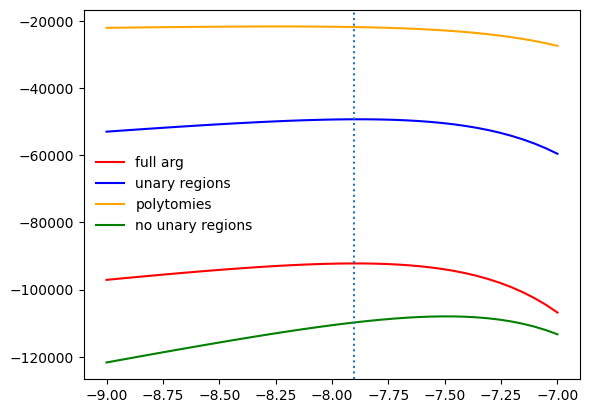

In [38]:
colors = ['black', 'red', 'blue', 'orange', 'green']
labels = ['hudson', 'full arg', 'unary regions', 'polytomies', 'no unary regions']
for i in [1,2,3,4]:
    plt.plot(np.log10(re_range), re_results[i], color=colors[i], label=labels[i])
plt.axvline(np.log10(REC), linestyle='dotted')
plt.legend(frameon=False);

In [39]:
#lik_ratio
re_rat = re_results - likelihood_true[:, np.newaxis]

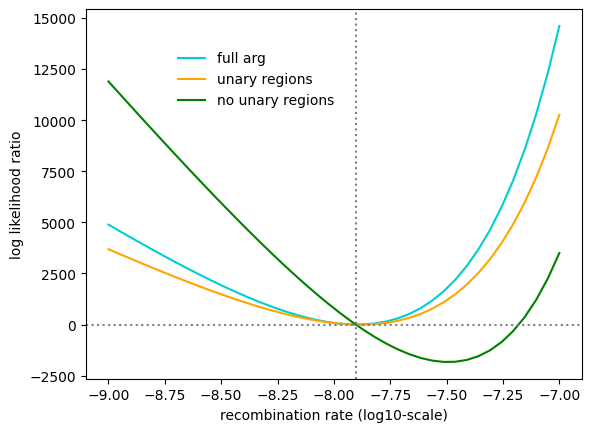

In [42]:
colors = ['black', 'darkturquoise', 'orange', 'red', 'green']
for i in [1,2,4]:
    plt.plot(np.log10(re_range), -re_rat[i], label=labels[i], color=colors[i])
plt.axvline(np.log10(REC), linestyle='dotted', color='gray')
plt.axhline(0.00, linestyle='dotted', color='gray')
#plt.ylim((0.975, 1.1))
plt.legend(frameon=False, bbox_to_anchor=(0.525,0.7));
plt.xlabel('recombination rate (log10-scale)')
plt.ylabel('log likelihood ratio')
#plt.savefig('re_liksurface.svg', bbox_inches='tight')